## IMPLEMENTASI LONG SHORT-TERM MEMORY (LSTM) UNTUK PREDIKSI HARGA BERAS

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

**Import Dataset**

In [2]:
df = pd.read_csv('data_harga_beras_ir64_2018_2022.csv')
df

,Date,IR64_I,IR64_II,IR64_III
0,2018-01-01,11800,11100,7800
1,2018-01-02,11850,11300,8400
2,2018-01-03,11950,11350,8400
3,2018-01-04,11975,11400,8400
4,2018-01-05,12050,11450,8800
...,...,...,...,...
1821,2022-12-27,11175,10400,9775
1822,2022-12-28,11175,10400,9775
1823,2022-12-29,11175,10400,9775
1824,2022-12-30,11175,10400,9800


**Grafik Dataset Harga Beras**

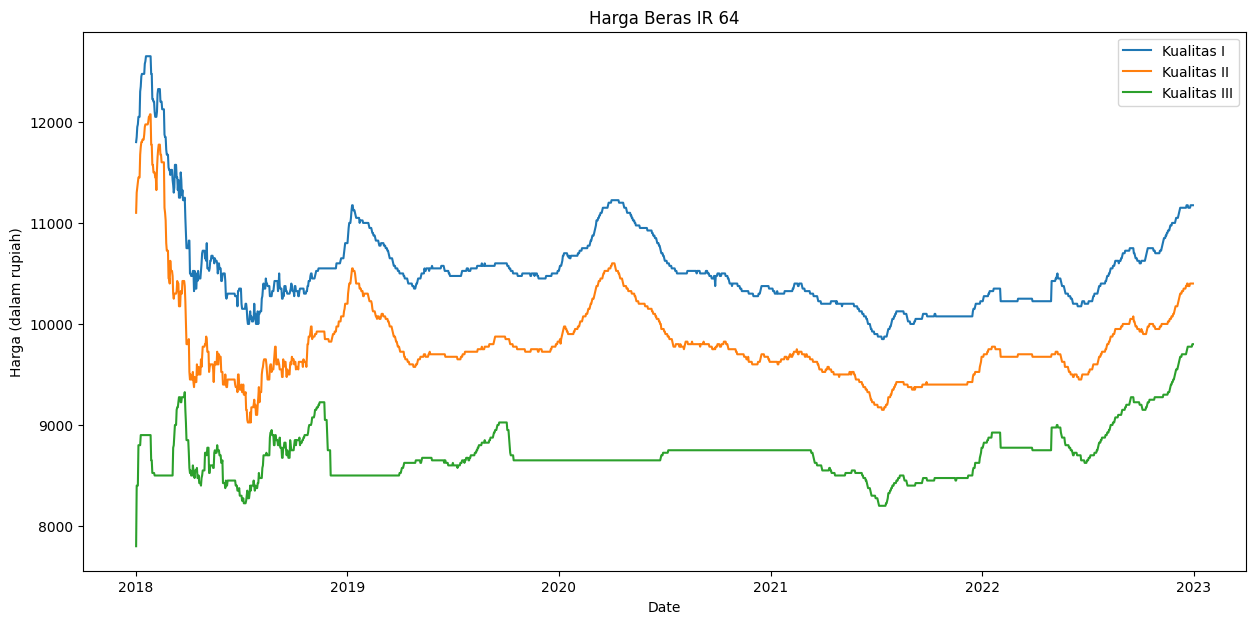

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(15,7))
plt.plot(df['Date'], df['IR64_I'], label='Kualitas I')
plt.plot(df['Date'], df['IR64_II'], label='Kualitas II')
plt.plot(df['Date'], df['IR64_III'], label='Kualitas III')

# Tambahkan label sumbu x, y, dan judul chart
plt.xlabel('Date')
plt.ylabel('Harga (dalam rupiah)')
plt.title('Harga Beras IR 64')

# Tampilkan legenda
plt.legend()

# Tampilkan chart
plt.show()

In [4]:
# Mengambil kolom 'Date' dari DataFrame df dan mengubahnya menjadi tipe data datetime
date_df = pd.to_datetime(df['Date'])

## EXPLORATORY DATA ANALYSIS

**Informasi Dataset**

In [5]:
# Menampilkan informasi tentang DataFrame `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1826 non-null   datetime64[ns]
 1   IR64_I    1826 non-null   int64         
 2   IR64_II   1826 non-null   int64         
 3   IR64_III  1826 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 57.2 KB


**Statistik Deskriptif**

In [6]:
# Menampilkan statistik deskriptif dari DataFrame `df`
df.describe()

,IR64_I,IR64_II,IR64_III
count,1826.000000,1826.000000,1826.000000
mean,10539.105696,9815.219058,8712.828587
std,437.304777,437.407094,255.133718
min,9850.000000,9025.000000,7800.000000
25%,10275.000000,9575.000000,8525.000000
50%,10475.000000,9725.000000,8650.000000
75%,10675.000000,9950.000000,8775.000000
max,12650.000000,12075.000000,9800.000000


**Cek Missing Value**

In [7]:
# Memeriksa jumlah nilai null (missing values) dalam setiap kolom 
df.isnull().sum()

Date        0
IR64_I      0
IR64_II     0
IR64_III    0
dtype: int64

## Data Preparation

In [8]:
# Menetapkan random seed
tf.random.set_seed(123)

**Drop Kolom**

In [9]:
# Melakukan drop pada kolom 'IR64 II' dan 'IR64 III'
df = df.drop(['IR64_II', 'IR64_III'], axis=1)

**Seleksi Data**

In [10]:
# Mengambil nilai dari kolom 'IR64 II', mengonversinya menjadi array, dan mengubah tipe data menjadi float32
df = df.filter(['IR64_I'])
df = df.values
df = df.astype('float32')

**Normalization**

Mengubah nilai-nilai ke dalam range antara 0 dan 1

In [11]:
# Normalisasi dataset dengan MinMaxScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df

array([[0.6964288 ],
       [0.71428585],
       [0.75      ],
       ...,
       [0.4732144 ],
       [0.4732144 ],
       [0.4732144 ]], dtype=float32)

**Data split & Time series windowing**

melakukan pembagian data menjadi data train dan data test dengan perbandingan 80:20, serta melakukan penyesuaian dimensi data untuk digunakan dalam model LSTM. Dilakukan juga reshapping atau mengubah bentuk dari masing-masing input data yang telah disiapkan menjadi tiga dimensi, yaitu (jumlah sampel, jumlah time steps, jumlah fitur) agar dapat digunakan sebagai input dalam model LSTM.

In [12]:
# Membagi dataset menjadi data latih dan data uji
n_samples = len(df)
train_size = int(n_samples * 0.8)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [13]:
# Time series windowing
def prepare_data(df, timesteps):
    X = []
    Y = []
    for i in range(len(df)-timesteps-1):
        a = df[i:(i+timesteps), 0]
        X.append(a)
        Y.append(df[i + timesteps, 0])
    return np.array(X), np.array(Y)

# Menentukan jumlah time steps (hari) yang digunakan untuk memprediksi harga beras berikutnya
timesteps = 1

# Persiapkan input dan output
X_train, Y_train = prepare_data(train_data, timesteps)
X_test, Y_test = prepare_data(test_data, timesteps)

In [14]:
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('Train Shape = {0}'.format(X_train.shape))
print('Test Shape = {0}'.format(X_test.shape))

Train Shape = (1458, 1, 1)
Test Shape = (364, 1, 1)


## Modelling

**Arsitektur LSTM**

* Dilakukan inisialisasi hyperparameter.

* Model LSTM dibuat dengan menggunakan objek Sequential dari library Keras. 

* Ditambahkan sebuah layer Dense dengan 1 neuron dan bias_initializer='zeros', yang berfungsi untuk menghasilkan output berupa harga beras. 

* Model dicompile dengan menggunakan optimizer Adam dan loss function mse, yang akan digunakan untuk mengukur seberapa besar selisih antara hasil prediksi dengan nilai yang sebenarnya.

* Model dilatih dengan menggunakan fungsi fit() yang memasukkan input dan output data training serta beberapa parameter seperti jumlah epoch, jumlah batch, dan validation data.

In [15]:
# Inisiasi Hyperparameter
num_neuron = 32
num_epoch = 50
num_batch = 16
Adam = Adam(learning_rate = 0.001)

# layer LSTM 
model = Sequential()
model.add(LSTM(4, activation = 'tanh', recurrent_activation = 'sigmoid', 
               return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(LSTM(num_neuron, activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = False))

model.add(Dense(1,bias_initializer='zeros'))

model.summary()

# Build model and compile
model.compile(optimizer = Adam, loss = 'mse', metrics=('MAPE'))

# Melatih model dengan menggunakan set data Training
# 
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = num_epoch, batch_size = num_batch, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
92/92 [==============================] - 20s 52ms/step - loss: 0.0395 - MAPE: 405575.3750 - val_loss: 0.0093 - val_MAPE: 48.2426
Epoch 2/50
92/92 [==============================] - 1s 7ms/step - loss: 0.0170 - MAPE: 555115.0000 - val_loss: 0.0058 - val_MAPE: 36.6990
Epoch 3/50
92/92 [======================

**Loss Visualization**

- untuk membandingkan perubahan nilai loss dan val loss selama proses pelatihan.
- membantu dalam mengevaluasi kinerja model terhadap data pelatihan dan data validasi.

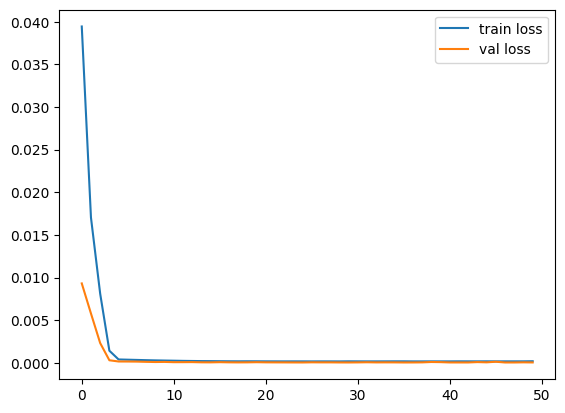

In [16]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

pada grafik diatas nilai loss pada data training dan data validasi sama-sama menurun seiring dengan bertambahnya jumlah epoch, maka dapat dikatakan model tersebut memperlihatkan performa yang baik dalam melakukan prediksi harga beras.

## Model Evaluation

Setelah melatih model LSTM, model tersebuat kemudian akan dievaluasi menggunakan MAE, RMSE, dan MAPE

In [17]:
train_predict = model.predict(X_train,verbose=0)
test_predict = model.predict(X_test,verbose=0)

# Menghitung MAE
mae = mean_absolute_error(Y_test, test_predict)
print('MAE = ', round(mae,4))

# Hitung RMSE
rmse = sqrt(mean_squared_error(Y_test, test_predict))
print('RMSE = ', round(rmse,4))

MAE =  0.0042
RMSE =  0.0065


In [18]:
test_mape = model.evaluate(X_test, Y_test)

12/12 [==============================] - 0s 4ms/step - loss: 4.2569e-05 - MAPE: 2.2924


**Visualization Data**

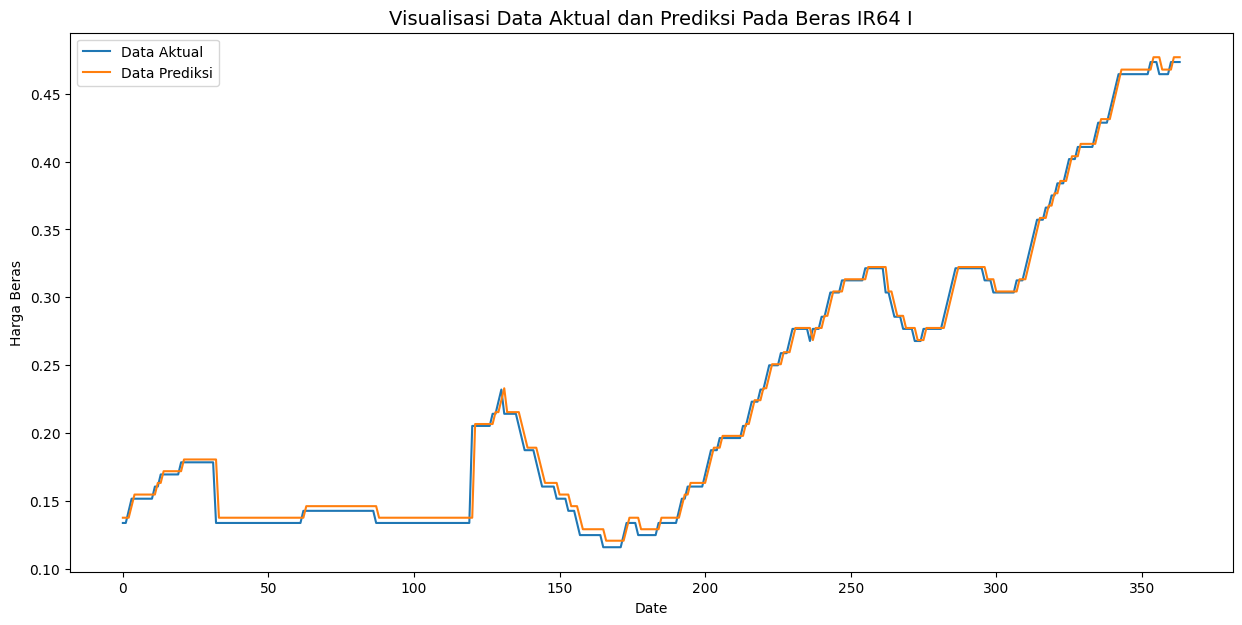

In [19]:
# Visualisasi data test (aktual) dan data hasil prediksi

plot_predict = model.predict(X_test, verbose=0)

plt.figure(figsize=(15,7))
plt.plot(Y_test, label = 'Data Aktual')
plt.plot(plot_predict, label = 'Data Prediksi')
plt.title('Visualisasi Data Aktual dan Prediksi Pada Beras IR64 I', fontsize=14)

plt.xlabel('Date')
plt.ylabel('Harga Beras')
plt.legend()
plt.show()

Setelah dilakukan visualisasi kemudian akan dilakukan invers scalinng agar data dapat ditampilkan dalam satuan yang sesuai dengan konteks awal. 

In [20]:
print("Data Test:")
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
print(Y_test)

Data Test:
[[10225.]
 [10225.]
 [10250.]
 [10275.]
 [10275.]
 [10275.]
 [10275.]
 [10275.]
 [10275.]
 [10275.]
 [10275.]
 [10300.]
 [10300.]
 [10325.]
 [10325.]
 [10325.]
 [10325.]
 [10325.]
 [10325.]
 [10325.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10350.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10250.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]
 [10225.]

In [21]:
print("Data Predict LSTM:")
plot_predict = scaler.inverse_transform(plot_predict)
print(plot_predict)

Data Predict LSTM:
[[10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10259.626 ]
 [10283.551 ]
 [10283.551 ]
 [10283.551 ]
 [10283.551 ]
 [10283.551 ]
 [10283.551 ]
 [10283.551 ]
 [10283.551 ]
 [10307.564 ]
 [10307.564 ]
 [10331.668 ]
 [10331.668 ]
 [10331.668 ]
 [10331.668 ]
 [10331.668 ]
 [10331.668 ]
 [10331.668 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10355.857 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10235.797 ]
 [10259.626 ]
 [10259.626 ]
 [10259.626 ]
 [10259.626 ]
 [10259.626 ]
 [10259.626 ]
 [10259.626 ]
 

## Prediksi Harga Beras Untuk Periode Ke Depan

Melakukan peramalan masa depan (future forecasting) menggunakan model yang telah dilatih. Tujuannya adalah untuk memberikan gambaran tentang prediksi nilai masa depan pada model yang telah dilatih, sehingga dapat digunakan sebagai acuan untuk pengambilan keputusan pada masa depan.

In [22]:
future_day = 31
last_date = date_df.iloc[-1] + pd.DateOffset(days=1)
dates_period = pd.date_range(last_date, periods=future_day, freq='1d').tolist()
future_model = model.predict(X_test[-future_day:])

1/1 [==============================] - 0s 47ms/step


In [23]:
# Inverse dan transform data forecast
forecast = np.repeat(future_model,X_test.shape[2],axis=1)
target = scaler.inverse_transform(forecast)[:,0]

forecast.shape

(31, 1)

In [24]:
# Create future forecast
forecast_future = []
for time_i in dates_period:
    forecast_future.append(time_i.date())
    len(forecast_future)
    
forecast_df= pd.DataFrame({'Date':np.array(forecast_future), 'IR64_I':target})
forecast_df['Date']=pd.to_datetime(forecast_df['Date'])

**Visualization Data Real dan Prediksi**

In [25]:
# Ignore Warning Notification
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

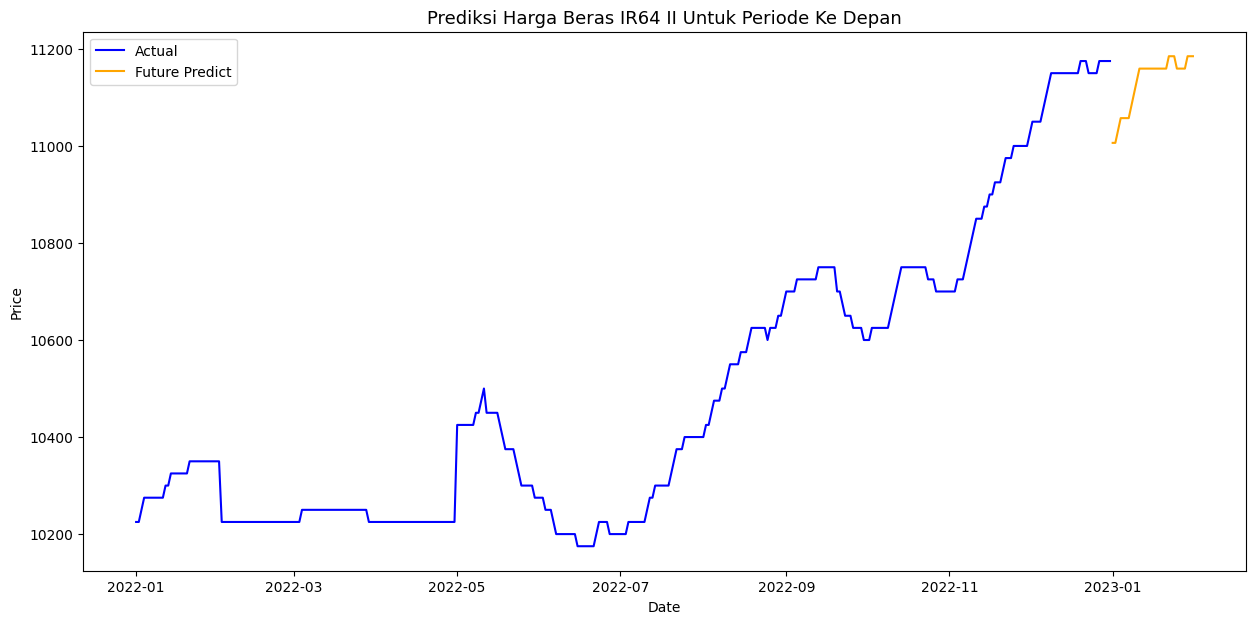

In [26]:
# Plotting data real dan hasil prediksi

df = pd.read_csv('data_harga_beras_ir64_2018_2022.csv')
actual = df[['Date', 'IR64_I']]
actual['Date']=pd.to_datetime(actual['Date'])
actual = actual.loc[actual['Date'] >= '2022-01-01'] # Year-Month-Day

# PLot Data
plt.figure(figsize=(15,7))
plt.plot(actual['Date'], actual['IR64_I'], label='Actual', color='b')
plt.plot(forecast_df['Date'], forecast_df['IR64_I'], label='Future Predict', color='orange')
plt.title('Prediksi Harga Beras IR64 II Untuk Periode Ke Depan', fontsize=13)
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

In [27]:
# Save data hasil prediksi ke file csv
forecast_df = forecast_df.set_index('Date')
forecast_df.to_csv('prediksi_ir64_i_masa_depan.csv')

**Membandingkan Data Real dan Data Prediksi**

In [28]:
# Memilih kolom 'IR64 II'
forecast_df = forecast_df.filter(['IR64_I'])
predict = forecast_df.values
predict = predict.astype('float32')

In [29]:
# Import data real harga beras IR64 II
real_df = pd.read_csv('harga_beras_real.csv')
real_df = real_df.filter(['IR64_I'])
real = real_df.values
real = real.astype('float32')

In [30]:
# Membuat DataFrame untuk data real dan data prediksi
real = pd.DataFrame(real)
future_forecast = pd.DataFrame(predict)

In [31]:
# Menggabungkan data real dan prediksi
df_final = pd.concat([real, future_forecast], axis=1)
df_final.columns = ['Harga Real', 'Harga Prediksi']
df_final.head(10)

,Harga Real,Harga Prediksi
0,11175.0,11006.331055
1,11175.0,11006.331055
2,11175.0,11031.829102
3,11200.0,11057.337891
4,11225.0,11057.337891
5,11250.0,11057.337891
6,11250.0,11057.337891
7,11250.0,11082.853516
8,11275.0,11108.372070
9,11300.0,11133.891602


**Evaluasi Data Prediksi Terhadap Data Real**

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

mape = (mean_absolute_percentage_error(real, predict)*100)
print('Nilai MAPE = ' ,(mape))

Nilai MAPE =  2.35240925103426
